In [19]:
import gym
import numpy as np
import sys
import time
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, namedtuple

%matplotlib inline
matplotlib.style.use('ggplot')

In [21]:
def epislon_greedy_policy(action_values, state, epislon=0.1):
    state_action_values = action_values[state]
    nA = state_action_values.shape[0]
    action_prob = np.ones((nA), dtype=np.float32) * epislon / nA
    action_prob[np.argmax(state_action_values)] = 1 - epislon + epislon / nA
    return np.random.choice(np.arange(nA), p=action_prob)

def QLeanring_core(env, max_episodes, learning_rate=0.5, discount=1.0, epislon=0.1, state_key_fun=None):
    nA = env.action_space.n
    action_values = defaultdict(lambda: np.zeros(nA, dtype=np.float32))
    record = namedtuple("Record", ["episode_steps", "episode_rewards"])
    record.episode_steps = []
    record.episode_rewards = []
    if(state_key_fun == None):
        state_key_fun = lambda x: x
    "对每一个终止状态的所有动作价值函数设置为0"
    "终止状态："
    for episode in range(max_episodes):
        state = env.reset()
        total_step = 0
        total_reward = 0
        while(True):
            "1.1 在某一幕的每一步中，根据动作价值函数Q，利用epislon贪婪选择一个动作(QLeanring独有)"
            state_key= state_key_fun(state)
            action = epislon_greedy_policy(action_values, state_key, epislon)
            "1.2 执行一个单步操作"
            next_state, reward, done, _ = env.step(action)
            # 将价值所对应的键值转化为方便映射的键值
            next_state_key = state_key_fun(next_state)
            "1.4 单步更新动作价值函数"
            "1.4.1 从下一个状态的动作价值函数中选择使其达到最大的动作(QLeanring独有)"
            next_optim_action = np.argmax(action_values[next_state_key])
            next_gain = reward + discount * action_values[next_state_key][next_optim_action]
            td_delta = next_gain - action_values[state_key][action]
            action_values[state_key][action] += learning_rate * td_delta
            # 进行调试记录
            total_step += 1
            total_reward += reward
            if(done):
                break
            state = next_state

        record.episode_steps.append(total_step)
        record.episode_rewards.append(total_reward)
    return action_values, record

In [22]:
class CartPole_QLearning():
    def __init__(self, env, max_episodes, learning_rate=0.5, discount=1.0, epislon=0.1, n_bins=10):
        self.env = env
        self.max_episodes = max_episodes
        self.learning_rate = learning_rate
        self.discount = discount
        self.epislon = epislon

        self.cart_position_bins = pd.cut([-2.4, 2.4], bins=n_bins, retbins=True)[1]
        self.pole_angle_bins = pd.cut([-2, 2], bins=n_bins, retbins=True)[1]
        self.cart_velocity_bins = pd.cut([-1, 1], bins=n_bins, retbins=True)[1]
        self.angle_rate_bins = pd.cut([-3.5, 3.5], bins=n_bins, retbins=True)[1]

    def get_bins_states(self, state):
        s1_, s2_, s3_, s4_ = state
        cart_position_idx = np.digitize(s1_, self.cart_position_bins)
        pole_angle_idx = np.digitize(s2_, self.pole_angle_bins)
        cart_velocity_idx = np.digitize(s3_, self.cart_velocity_bins)
        angle_rate_idx = np.digitize(s4_, self.angle_rate_bins)

        state_ = [cart_position_idx, pole_angle_idx,
                  cart_velocity_idx, angle_rate_idx]

        state = map(lambda s: int(s), state_)
        return tuple(state)

    def QLearning(self):
        return QLeanring_core(self.env, self.max_episodes, \
        self.learning_rate, self.discount, self.epislon, state_key_fun=self.get_bins_states)


In [23]:
env = gym.make("CartPole-v0")
qlearning = CartPole_QLearning(env, max_episodes=200)
Q, record = qlearning.QLearning()

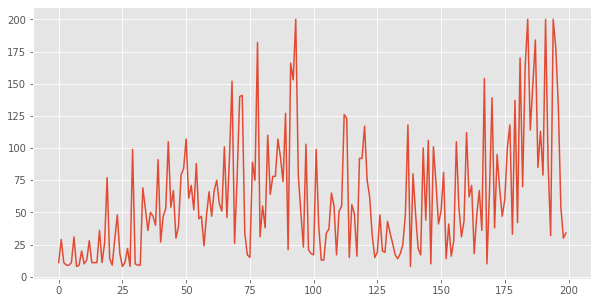

In [24]:
fig1 = plt.figure(figsize=(10,5))
plt.plot(record.episode_steps[:200])